In [1]:
import os 
from os.path import dirname, join, realpath
from typing import List, Optional, Tuple
import tqdm

import torch
import skimage.io

import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

from pytorch3d.implicitron.tools.config import (
    expand_args_fields,
    registry,
    run_auto_creation,
)
from pytorch3d.io import IO
from pytorch3d.structures import Volumes
from pytorch3d.vis.plotly_vis import plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    AmbientLights,
    BlendParams,
    CamerasBase,
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher, 
    VolumeRenderer,
    VolumeSampler,
)

from pytorch3d.implicitron.dataset.dataset_map_provider import (
    DatasetMap, 
    DatasetMapProviderBase, 
    PathManagerFactory
)
from pytorch3d.implicitron.dataset.dataset_base import FrameData
from pytorch3d.implicitron.dataset.single_sequence_dataset import SingleSceneDataset
from pytorch3d.implicitron.dataset.utils import DATASET_TYPE_KNOWN

resolution = 256

In [2]:
@torch.no_grad()
def _generate_volume_renders(
    *,
    num_views: int,
    volumes: Volumes,
    azimuth_range: float,
    resolution: int,
    device: torch.device,
    use_point_light: bool,
) -> Tuple[CamerasBase, torch.Tensor, torch.Tensor]:
    """
    Returns:
        cameras: A batch of `num_views` `FoVPerspectiveCameras` from which the
            images are rendered.
        images: A tensor of shape `(num_views, height, width, 3)` containing
            the rendered images.
        depths: A tensor of shape `(num_views, height, width)` containing
            the rendered depths.
    """

    # Get a batch of viewing angles.
    elev = torch.linspace(0, 0, num_views)  # keep constant
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Place a point light in front of the object. As mentioned above, the front of
    # the cow is facing the -z direction.
    if use_point_light:
        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    else:
        lights = AmbientLights(device=device)

    # Initialize an OpenGL perspective camera that represents a batch of different
    # viewing angles. All the cameras helper methods support mixed type inputs and
    # broadcasting. So we can view the camera from the a distance of dist=2.7, and
    # then specify elevation and azimuth angles for each viewpoint as tensors.
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    raysampler = NDCMultinomialRaysampler( #NDCGridRaysampler(
        image_width = resolution,
        image_height = resolution,
        n_pts_per_ray = 300, 
        min_depth = 0.1,
        max_depth = 4.5,
    )

    raymarcher = EmissionAbsorptionRaymarcher() # X-Ray Raymarcher

    renderer = VolumeRenderer(
        raysampler = raysampler, 
        raymarcher = raymarcher,
    )

    # volumes = volume.extend(num_views)

    # Render the cow mesh from each viewing angle
    target_images = renderer(volumes=volumes, cameras=cameras, lights=lights)[0]
    target_images /= target_images.max()
    return cameras, target_images, target_images

In [3]:
# @registry.register
class RenderedVolumesDatasetMapProvider(DatasetMapProviderBase):  # pyre-ignore [13]
    """
        num_views: The number of generated renders.
        data_file: The folder that contains the volume file. By default, 
        azimuth_range: number of degrees on each side of the start position to
            take samples
        resolution: the common height and width of the output images.
        use_point_light: whether to use a particular point light as opposed
            to ambient white.
    """

    num_views: int = 40
    data_file: Optional[str] = None
    azimuth_range: float = 180
    resolution: int = 200
    use_point_light: bool = True
    path_manager_factory: PathManagerFactory
    path_manager_factory_class_type: str = "PathManagerFactory"

    def get_dataset_map(self) -> DatasetMap:
        # pyre-ignore[16]
        return DatasetMap(train=self.train_dataset, val=None, test=None)

    def get_all_train_cameras(self) -> CamerasBase:
        # pyre-ignore[16]
        return self.poses

    def __post_init__(self) -> None:
        super().__init__()
        run_auto_creation(self)
        # if torch.cuda.is_available():
        #     device = torch.device("cuda:1")
        # else:
            # device = torch.device("cpu")
        # device = torch.device("cuda:1")
        device = torch.device("cpu")
        if self.data_file is None:
            # data_file = join(
            #     dirname(dirname(dirname(dirname(realpath(__file__))))),
            #     "docs",
            #     "tutorials",
            #     "data",
            #     "cow_mesh",
            #     "cow.obj",
            # )
            data_file = "Engine.tif"
        else:
            data_file = self.data_file
        
        # Read the data
        import skimage.io
        import numpy as np
        data = skimage.io.imread(data_file).astype(np.float32) / 255.0
        features = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).repeat(self.num_views, 3, 1, 1, 1)
        densities = features.mean(dim=1, keepdim=True) / 10.0
        # io = IO(path_manager=self.path_manager_factory.get())
        # mesh = io.load_mesh(data_file, device=device)
        volumes = Volumes(
            features = features, 
            densities = densities,
            voxel_size = 3.0 / self.resolution,
        ).to(device)

        poses, images, depths = _generate_volume_renders(
            num_views=self.num_views,
            volumes=volumes,
            azimuth_range=self.azimuth_range,
            resolution=self.resolution,
            device=device,
            use_point_light=self.use_point_light,
        )
        # pyre-ignore[16]
        self.poses = poses.cpu()
        expand_args_fields(SingleSceneDataset)
        # pyre-ignore[16]
        self.train_dataset = SingleSceneDataset(  # pyre-ignore[28]
            object_name="engine",
            images=list(images.permute(0, 3, 1, 2).cpu()),
            fg_probabilities=list(depths[:, None].cpu()),
            poses=[self.poses[i] for i in range(len(poses))],
            frame_types=[DATASET_TYPE_KNOWN] * len(poses),
            eval_batches=None,
        )

In [4]:
engine_provider = RenderedVolumesDatasetMapProvider(
    data_file="Engine.tif",
    use_point_light=True,
    resolution=resolution, 
    num_views=45
)

In [5]:
dataset_map = engine_provider.get_dataset_map()
tr_cameras = [training_frame.camera for training_frame in dataset_map.train]

In [6]:
# The cameras are all in the XZ plane, in a circle about 2.7 from the origin
centers = torch.cat([i.get_camera_center() for i in tr_cameras])
print(centers.min(0).values)
print(centers.max(0).values)

tensor([-2.7000,  0.0000, -2.7000])
tensor([2.7000, 0.0000, 2.7000])


In [7]:
# visualization of the cameras
plot = plot_scene({"k": {i: camera for i, camera in enumerate(tr_cameras)}}, camera_scale=0.25)
plot.layout.scene.aspectmode = "data"
plot

100%|██████████| 45/45 [00:00<00:00, 2516.62it/s]


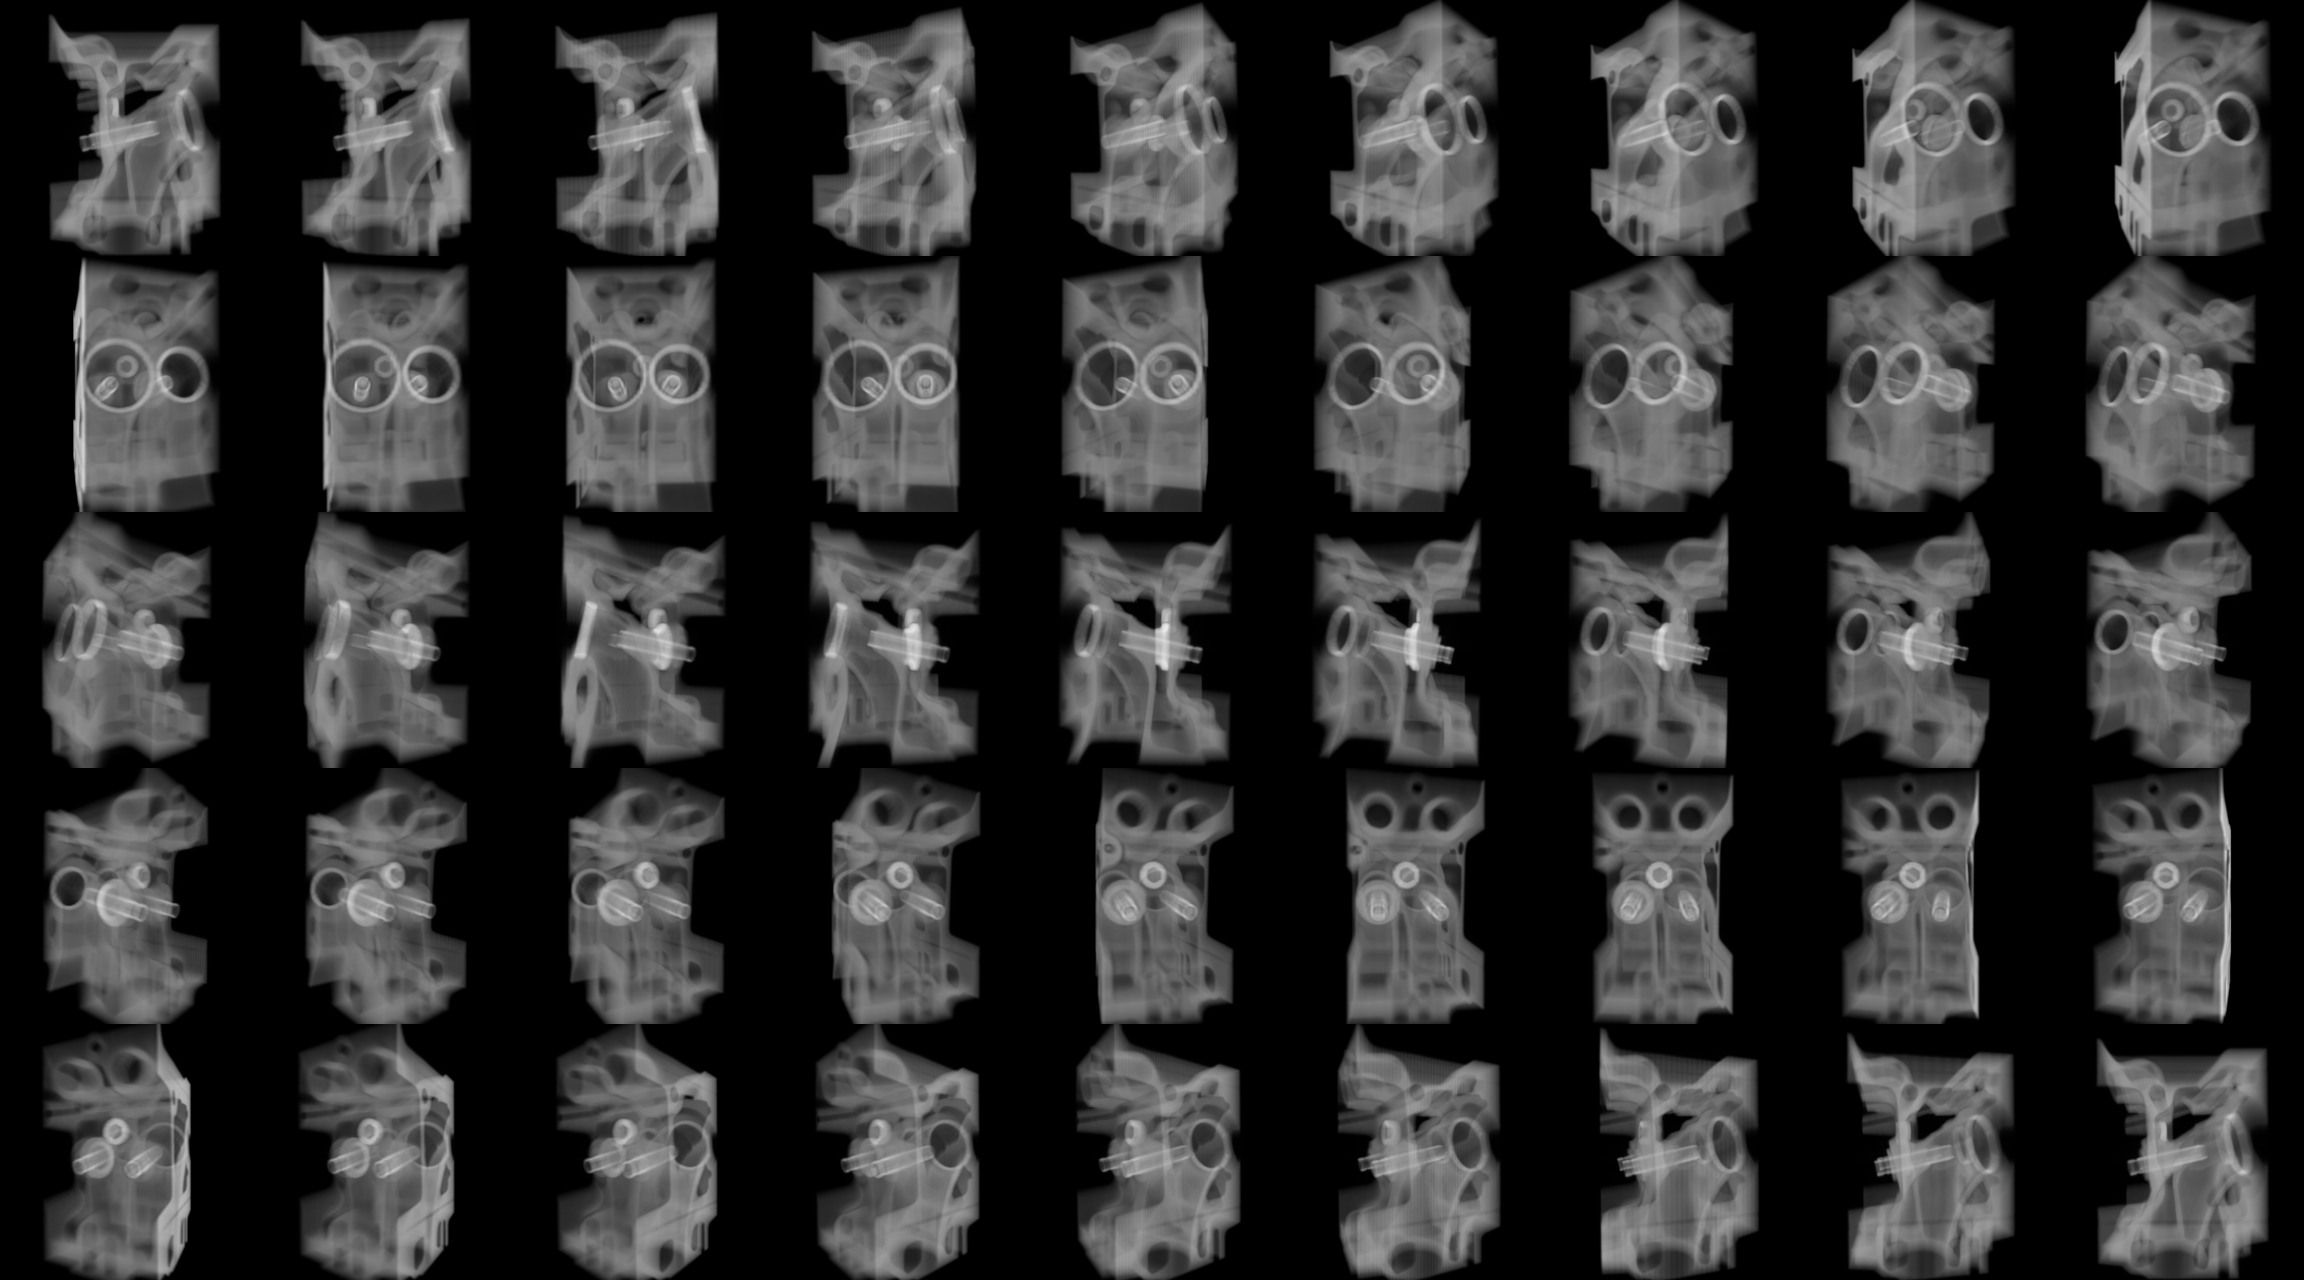

In [8]:
def to_numpy_image(image):
    # Takes an image of shape (C, H, W) in [0,1], where C=3 or 1
    # to a numpy uint image of shape (H, W, 3)
    return (image[:3] * 255).to(torch.uint8).permute(1, 2, 0).detach().cpu().expand(-1, -1, 3).numpy()
def resize_image(image):
    # Takes images of shape (B, C, H, W) to (B, C, output_resolution, output_resolution)
    return torch.nn.functional.interpolate(image, size=(resolution, resolution))

import numpy as np 

train_data_collated = [FrameData.collate([frame.to(torch.device("cpu"))]) for frame in dataset_map.train]
images = []
masks = []
for frame in tqdm.tqdm(train_data_collated):

    image_rgb = to_numpy_image(resize_image(frame.image_rgb)[0])
    mask = to_numpy_image(resize_image(frame.image_rgb)[0])

    images.append(image_rgb)
    masks.append(mask)

# images_to_display = [images.copy(),  masks.copy()]
images_to_display = [images.copy()]
n_rows = 5
n_images = len(images)
blank_image = images[0] * 0
n_per_row = 1+(n_images-1)//n_rows
for _ in range(n_per_row*n_rows - n_images):
    for group in images_to_display:
        group.append(blank_image)

images_to_display_listed = [[[i] for i in j] for j in images_to_display]
split = []
for row in range(n_rows):
    for group in images_to_display_listed:
        split.append(group[row*n_per_row:(row+1)*n_per_row])  

from PIL import Image
Image.fromarray(np.block(split))

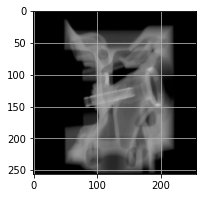

In [9]:
import logging
from typing import Tuple

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from IPython.display import HTML
from omegaconf import OmegaConf

plt.ioff()
fig, ax = plt.subplots(figsize=(3, 3))

ax.grid(None)
ims = [[ax.imshow(im, animated=True)] for im in images]
ani = animation.ArtistAnimation(fig, ims, interval=80, blit=True)
ani_html = ani.to_jshtml()

In [10]:
HTML(ani_html)